In [32]:
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, average_precision_score

In [33]:
import utils as u
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


put "techniques" folder to data in the working directory: dir/data/  
then we get data from dir/data/techniques/xxxx.wav

In [34]:
from pathlib import Path


# Define paths
project_dir = Path.cwd().parents[0]
# Project Dir, the parent folder of this script folder

technique_dir = project_dir / "data/techniques"  # Folder with .wav files
technique_dir = str(technique_dir)
# technique_dir from last line is a path object, convert to string for compatibility with other code

# output_dir = project_dir / "computed_features/spectrogram"
# # Where .pt files will be saved
# output_dir.mkdir(parents=True, exist_ok=True)

In [35]:
# define split ratio for train/test sets
split_ratio = 0.8
# do not modify to a value other than 0.8

In [36]:
# import librosa

# max_length = 0

# for track in train_dataloader:
#     audio_path = track["audio_path"]
#     audio, sr = librosa.load(audio_path, sr=None)  # Load audio
#     duration = librosa.get_duration(y=audio, sr=sr)  # Get audio duration
#     max_length = max(max_length, duration)

# print(f"The maximum audio length is: {max_length} seconds")

# about 270 seconds max
# we can use 280 seconds, instead of 300 seconds, to avoid wasting space

maximum length of audio about 270 seconds max  
we can use 280 seconds, instead of 300 seconds, to avoid wasting space

Keep the split ratio as 0.8 for now!  
The train, val, split now has at least a basic good distribution  
for example switch to ratio 0.85, will result in val set have 0 tracks for staccato

In [37]:
from utils import TechniqueDataloader

train_dataloader = TechniqueDataloader(
    mode="train",
    split_ratio=split_ratio,
    rs=42,
    label="single",
    technique_dir=technique_dir,
)
val_dataloader = TechniqueDataloader(
    mode="val",
    split_ratio=split_ratio,
    rs=42,
    label="single",
    technique_dir=technique_dir,
)
test_dataloader = TechniqueDataloader(
    mode="test",
    split_ratio=split_ratio,
    rs=42,
    label="single",
    technique_dir=technique_dir,
)
print(f"Train set size: {len(train_dataloader)}")
print(f"Validation set size: {len(val_dataloader)}")
print(f"Test set size: {len(test_dataloader)}")
print(
    f"Data set size: {len(train_dataloader) + len(test_dataloader)+ len(val_dataloader)}"
)

Train set size: 132
Validation set size: 45
Test set size: 45
Data set size: 222


keep only single-label tracks, filter out multi-labels

In [38]:
from utils import filter_single_label_tracks

# for a given label array a=[0,0,0,0,1,0,0], use sum(a) == 1 to check if it is a single-labeled track

# Filter single-labeled tracks from train and test dataloaders
train_dataloader_filtered = filter_single_label_tracks(train_dataloader)
val_dataloader_filtered = filter_single_label_tracks(val_dataloader)
test_dataloader_filtered = filter_single_label_tracks(test_dataloader)

# Step 5: Print results for filtered dataloaders
print(f"Filtered Train set size: {len(train_dataloader_filtered)}")
print(f"Filtered Validation set size: {len(val_dataloader_filtered)}")
print(f"Filtered Test set size: {len(test_dataloader_filtered)}")

Filtered Train set size: 104
Filtered Validation set size: 36
Filtered Test set size: 40


# Look at data distribution

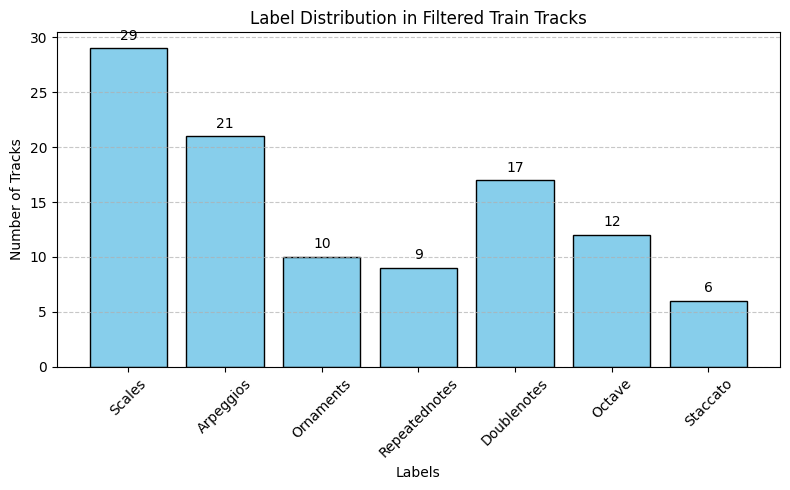

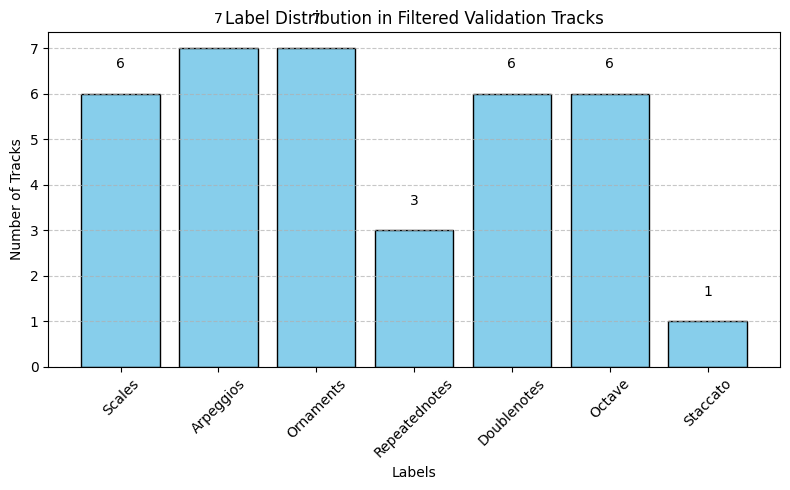

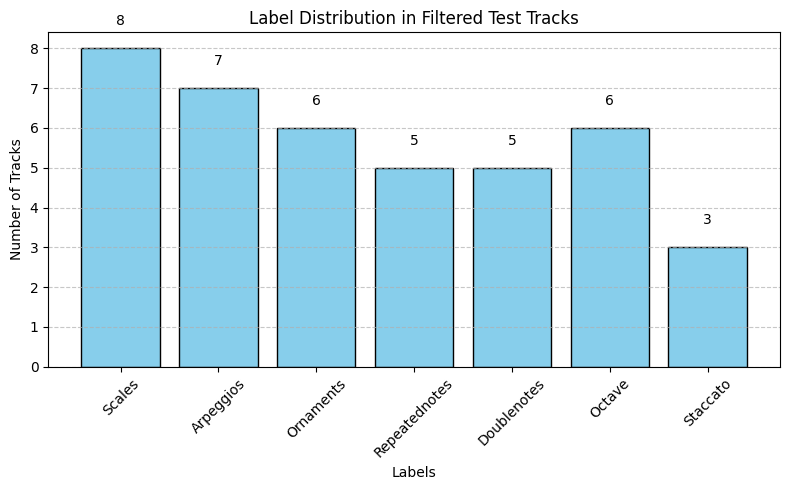

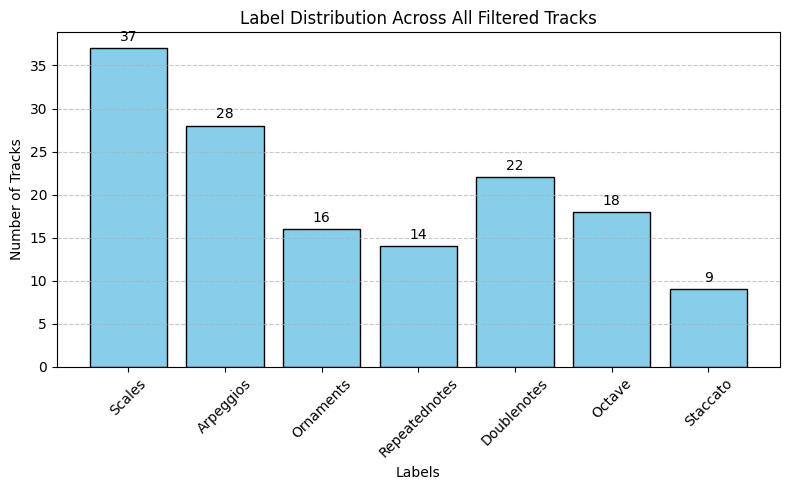

In [39]:
from utils import plot_label_distribution

# Plot distributions
plot_label_distribution(
    train_dataloader_filtered,
    train_dataloader.label_columns,
    "Label Distribution in Filtered Train Tracks",
)
plot_label_distribution(
    val_dataloader_filtered,
    train_dataloader.label_columns,
    "Label Distribution in Filtered Validation Tracks",
)
plot_label_distribution(
    test_dataloader_filtered,
    train_dataloader.label_columns,
    "Label Distribution in Filtered Test Tracks",
)
import pandas as pd

# Combine metadata from both dataloaders
combined_metadata = pd.concat(
    [train_dataloader_filtered.metadata, test_dataloader_filtered.metadata],
    ignore_index=True,
)

# Create a new TechniqueDataloader instance with the combined metadata
combined_dataloader = TechniqueDataloader(
    mode="combined",  # Custom mode for the combined dataloader
    split_ratio=1.0,  # Use all combined data
    rs=None,
    label=train_dataloader_filtered.label,  # Use the same label type
    technique_dir=train_dataloader_filtered.technique_dir,
)

# Set the combined metadata
combined_dataloader.metadata = combined_metadata

# Plot label distribution for the combined dataloader
plot_label_distribution(
    combined_dataloader,
    train_dataloader_filtered.label_columns,
    "Label Distribution Across All Filtered Tracks",
)

# Look at spectrogram, and hear an example

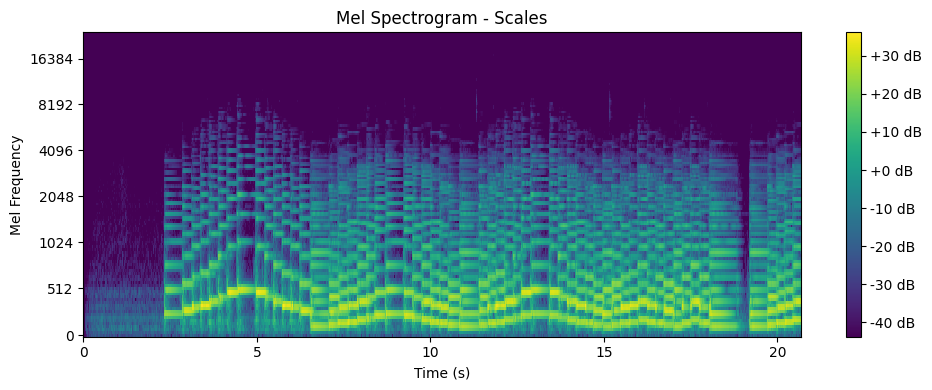

In [40]:
# Load an example audio file and compute its mel spectrogram
track = train_dataloader_filtered[0]  # Get the path of the first audio file

from utils import display_track_spec_audio

display_track_spec_audio(track)

# Compute embeddings using the below cell

In [41]:
train_features, train_labels = u.get_spectrogram_and_labels(train_dataloader_filtered)


val_features, val_labels = u.get_spectrogram_and_labels(val_dataloader_filtered)


test_features, test_labels = u.get_spectrogram_and_labels(test_dataloader_filtered)


print(train_features.shape)


print(train_labels.shape)


print(val_features.shape)


print(val_labels.shape)


print(test_features.shape)


print(test_labels.shape)

Label for track: 0
Processing track 1/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/v72Hi1TIAFQ.wav
Original audio shape: (1984471,)
Track 0, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 2/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Doublenotes_6.wav
Original audio shape: (1352871,)
Track 1, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 3/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/7sdmulntks4.wav
Original audio shape: (3785596,)
Track 2, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 6
Processing track 4/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/9pmAuRz7AjE_cut.wav


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Original audio shape: (684647,)
Track 3, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 5/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/FEjU3QR3Sds.wav
Original audio shape: (931214,)
Track 4, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 6/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/3XcgoAl5WvI_cut.wav
Original audio shape: (1357933,)
Track 5, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 7/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/sxlXBMYkbkQ.wav
Original audio shape: (2524474,)
Track 6, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 5
Processing track 8/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/VZiM-rLNUos_cut.wav
Original audio shape: (3525497,)
Track 7, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 9/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/X9RX0Du0X_w.wav
Original audio shape: (1142422,)
Track 8, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 10/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/fjkKhLkyIMo.wav
Original audio shape: (6150131,)


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Track 9, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 11/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/uDZdMMWyxtM.wav
Original audio shape: (1968310,)
Track 10, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 12/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/6VQ1wr28kik_cut.wav
Original audio shape: (3681159,)
Track 11, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Label for track: 4
Processing track 13/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/MwJ8MV26eZs.wav
Original audio shape: (1782178,)
Track 12, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 14/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/71qZ-BnhenI.wav
Original audio shape: (2780160,)
Track 13, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 15/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/hkgt_NcQF6s.wav
Original audio shape: (4072595,)
Track 14, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Label for track: 6
Processing track 16/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/YYE3N8sVzyQ.wav
Original audio shape: (1758773,)
Track 15, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 17/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/B4qtWa7uzqQ.wav
Original audio shape: (2518016,)
Track 16, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 18/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/rPeR98tXglE.wav
Original audio shape: (1634500,)
Track 17, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 19/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/MvuVChCz2Gk.wav
Original audio shape: (465886,)
Track 18, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 1
Processing track 20/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/BiL7YPcezpU.wav
Original audio shape: (1054929,)
Track 19, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 21/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/PAKtfkh0C1M_cut7.wav
Original audio shape: (665851,)
Track 20, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 22/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/GTEQhRwGwEI.wav
Original audio shape: (870470,)
Track 21, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 23/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/yWFzqMZvLYQ.wav
Original audio shape: (1900322,)
Track 22, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 0
Processing track 24/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/b1GU9fpks4M.wav
Original audio shape: (1536976,)
Track 23, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 25/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_3.wav
Original audio shape: (891879,)
Track 24, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 26/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Repeatednotes_ravel_2.wav
Original audio shape: (960557,)
Track 25, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 27/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Nw1BAqrKvjM.wav
Original audio shape: (1438337,)
Track 26, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Proc

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Original audio shape: (3381569,)
Track 27, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 29/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/rqnUhZLlgsU.wav
Original audio shape: (703286,)
Track 28, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 30/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/pJ5UmwxdaEM.wav
Original audio shape: (1205248,)
Track 29, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 31/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_franck_1.wav
Original audio shape: (1943693,)
Track 30, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 32/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/xXi3dl5R92c_cut5.wav
Original audio shape

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Label for track: 3
Processing track 33/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/_lW2AXcugp4.wav
Original audio shape: (11693384,)
Track 32, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Label for track: 5
Processing track 34/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/M1dGRk9lYl4.wav
Original audio shape: (6335147,)
Track 33, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 35/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/ZNxCuihDFeU.wav
Original audio shape: (1100626,)
Track 34, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 36/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/GJ4qCMacMlA_cut2.wav
Original audio shape: (429808,)
Track 35, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 2
Processing track 37/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/STy9GPeuNEY_cut.wav
Original audio shape: (479437,)
Track 36, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 38/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/5W-XBL5COxI.wav
Original audio shape: (1702488,)
Track 37, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 39/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/2g_ddZ-IceU.wav
Original audio shape: (3312466,)
Track 38, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 40/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/6IgJQ5aUiRU.wav
Original audio shape: (1044341,)
Track 39, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 1
Processing track 41/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/eme_SAE6rok.wav
Original audio shape: (3964483,)
Track 40, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 6
Processing track 42/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Staccato_1.wav
Original audio shape: (697133,)
Track 41, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 43/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/RwBVzJFW46Q.wav
Original audio shape: (696042,)
Track 42, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 44/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/BqiSIOFQSFk.wav
Original audio shape: (1145766,)
Track 43, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing t

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Label for track: 4
Processing track 47/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Doublenotes_1.wav
Original audio shape: (707481,)
Track 46, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 48/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/ZXWcf-P3I3k.wav
Original audio shape: (315420,)
Track 47, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 49/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/AePvsx9w9f4_cut.wav
Original audio shape: (893486,)
Track 48, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 50/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_e_mior.wav
Original audio shape: (449703,)
Track 49, resample from 44100 to 24000
Target length in samp

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 2
Processing track 52/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/CX4-RAL0TBo.wav
Original audio shape: (2454257,)
Track 51, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 53/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/N6HcdKlAzkE_cut.wav
Original audio shape: (2582334,)
Track 52, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 54/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_ravel_1.wav
Original audio shape: (2090457,)
Track 53, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 55/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_franck_3.wav
Original audio shape: (1175060,)


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Track 54, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 56/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/S6Zf7bzha8w.wav
Original audio shape: (4802073,)
Track 55, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 57/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/VnH4b-eYQDc.wav
Original audio shape: (4344547,)


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Track 56, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 58/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/caR2SSD2JlY.wav
Original audio shape: (1855182,)
Track 57, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 59/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/bdYhyPH6jbY.wav
Original audio shape: (1861312,)
Track 58, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 60/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/etq0pqpSNqQ.wav
Original audio shape: (559509,)
Track 59, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 5
Processing track 61/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_5.wav
Original audio shape: (1085684,)
Track 60, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 62/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/rXcSlDXCfR8.wav
Original audio shape: (905021,)
Track 61, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 63/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/t_nxp263oUY.wav
Original audio shape: (1251649,)
Track 62, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 6
Processing track 64/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/g_jUWqYsNzw_cut.wav
Original audio shape: (2262309,)
Track 63, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 4
Processing track 65/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/4QtkdA_coBQ.wav
Original audio shape: (1023722,)
Track 64, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 66/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/EDhSoKdU_hY.wav
Original audio shape: (913938,)
Track 65, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 67/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/dXVXdemjr8o.wav
Original audio shape: (1782736,)
Track 66, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 68/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/yCNL6URpwXQ.wav
Original audio shape: (614679,)
Track 67, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing 

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Original audio shape: (3698103,)
Track 68, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 70/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/SiXmnSXShdc.wav
Original audio shape: (3643490,)
Track 69, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 71/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/lM6Ecj24-nU.wav
Original audio shape: (5407835,)
Track 70, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 72/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/w1JJaDFGxgU.wav
Original audio shape: (2980885,)
Track 71, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 73/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Y5CsDc2Cpzo.wav
Original audio shape: (31363

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Label for track: 2
Processing track 74/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/yBDSkjV5_wQ_cut.wav
Original audio shape: (1125961,)
Track 73, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 75/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Ri9ne7AV1K0.wav
Original audio shape: (6219790,)
Track 74, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 76/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/PAKtfkh0C1M_cut2.wav
Original audio shape: (505649,)
Track 75, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 6
Processing track 77/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/93VqAV8YDSY.wav


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Original audio shape: (3251166,)
Track 76, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 78/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/cTii-snuNLc.wav
Original audio shape: (4869504,)
Track 77, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 79/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/nRV1tNXp1E0.wav
Original audio shape: (1787751,)
Track 78, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 80/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/6N6W0PDBRHs.wav


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Original audio shape: (4837739,)
Track 79, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 81/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/BbVY3PQlpvs.wav
Original audio shape: (1256664,)
Track 80, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 82/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/0W_guhYZypI.wav
Original audio shape: (4016867,)
Track 81, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 83/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/wZnoYThr2As.wav


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Original audio shape: (3202682,)
Track 82, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 84/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Doublenotes_5.wav
Original audio shape: (662324,)
Track 83, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 85/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/qcsNTWUKfmY.wav
Original audio shape: (2232460,)
Track 84, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 86/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/BYVIhBTElEs.wav
Original audio shape: (941245,)
Track 85, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 4
Processing track 87/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Doublenotes_4.wav
Original audio shape: (834489,)
Track 86, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 6
Processing track 88/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/79VIXjBFK_I.wav
Original audio shape: (1778278,)
Track 87, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 89/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Sl1Z_dglxlo.wav
Original audio shape: (3946650,)
Track 88, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 90/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/te5duc9WAh0.wav
Original audio shape: (747869,)
Track 89, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 0
Processing track 91/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/V52WdeAhadQ.wav
Original audio shape: (1787751,)
Track 90, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 92/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_franck_2.wav
Original audio shape: (1538208,)
Track 91, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 93/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/gq1W0DAb6pU.wav
Original audio shape: (2108187,)
Track 92, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 94/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/rFh7RwyfgI0.wav
Original audio shape: (2880018,)
Track 93, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Proce

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 0
Processing track 98/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/faAJ3HbGD_g.wav
Original audio shape: (2116546,)
Track 97, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 99/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/C3G8DUFYQjk.wav
Original audio shape: (1187005,)
Track 98, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 100/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/-0gQ_A3tP1c.wav
Original audio shape: (3635688,)
Track 99, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 101/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/I5rASCtR6Bo.wav


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Original audio shape: (2192336,)
Track 100, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 102/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/31_T8OKn4-w.wav
Original audio shape: (5239537,)
Track 101, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 103/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_1.wav
Original audio shape: (1575840,)
Track 102, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 104/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/0YyH44KJ2S8.wav


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Original audio shape: (2769677,)
Track 103, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Execution completed, saving features and tensor as .pt file
Feature tensor shape: torch.Size([104, 6, 1500, 128])
Label tensor shape: torch.Size([104])
Project directory: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent
Saving features and labels to: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram
Features and labels saved successfully for split 'train' in c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram.
Label for track: 5
Processing track 1/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/McoqNuF6TpQ.wav
Original audio shape: (4155072,)
Track 0, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 2/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/JrJHc__2jOk.wav
Original audio shape: (635298,)
Track 1, resample from 48000 to 24000
Target length in samples: 1440000
Label for track

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Original audio shape: (892317,)
Track 3, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 5/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Bei7Hazlwjg.wav
Original audio shape: (1681868,)
Track 4, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 6
Processing track 6/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Staccato_3.wav
Original audio shape: (798740,)
Track 5, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 7/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/ttp2QX0O9ko.wav


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Original audio shape: (10666876,)
Track 6, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 8/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/xXi3dl5R92c_cut2.wav
Original audio shape: (285481,)
Track 7, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 9/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/MP_3kWh0Gr4.wav
Original audio shape: (2153326,)
Track 8, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 10/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_4.wav
Original audio shape: (938919,)
Track 9, resample from 44100 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 4
Processing track 11/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Z2A1Fm_luXs.wav
Original audio shape: (2909554,)
Track 10, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 12/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/JRiumYw-buA_cut1.wav
Original audio shape: (399142,)
Track 11, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 13/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Ornaments_3.wav
Original audio shape: (1233389,)
Track 12, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 14/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/cosIrQauQbU_cut.wav
Original audio shape: (844516,)
Track 13, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 1
Processing track 15/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/UM-Rx6c1Ny0.wav
Original audio shape: (747312,)
Track 14, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 16/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/PAKtfkh0C1M_cut3.wav
Original audio shape: (1221668,)
Track 15, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 17/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/YPds_ZgooTs.wav
Original audio shape: (1565954,)
Track 16, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 18/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/pGGHFf8XZAQ.wav
Original audio shape: (2993703,)
Track 17, resample from 48000 to 24000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Target length in samples: 1440000
Label for track: 1
Processing track 19/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_e7.wav
Original audio shape: (644448,)
Track 18, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 20/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_6.wav
Original audio shape: (892820,)
Track 19, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 21/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/nsXT6p3AsrM.wav
Original audio shape: (2703918,)
Track 20, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Label for track: 2
Processing track 22/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/xXi3dl5R92c_cut1.wav
Original audio shape: (432912,)
Track 21, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 23/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/VYa5Rt1kKzQ.wav
Original audio shape: (6304497,)
Track 22, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 24/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/UhG9pPAcsHg.wav
Original audio shape: (1440009,)
Track 23, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 25/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Ornaments_1.wav
Original audio shape: (766752,)
Track 24, resample from 44100 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 5
Processing track 26/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_1.wav
Original audio shape: (814733,)
Track 25, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 27/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/ro0QRhprRf4.wav
Original audio shape: (3440640,)
Track 26, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 28/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/QJ7MU87qDrc.wav
Original audio shape: (3022681,)
Track 27, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 29/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/piECZCUMquY.wav


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Original audio shape: (750655,)
Track 28, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 30/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/YAWrQ_OrOvc.wav
Original audio shape: (1982799,)
Track 29, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 31/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Ornaments_4.wav
Original audio shape: (1003833,)
Track 30, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 32/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/jKjLp38TY5w.wav
Original audio shape: (12592275,)
Track 31, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 33/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Yr50r0XOqe8.wav
Original audio shape: (212881,)


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Original audio shape: (9143276,)
Track 34, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 36/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Repeatednotes_ravel_1.wav
Original audio shape: (429945,)
Track 35, resample from 44100 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Execution completed, saving features and tensor as .pt file
Feature tensor shape: torch.Size([36, 6, 1500, 128])
Label tensor shape: torch.Size([36])
Project directory: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent
Saving features and labels to: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram
Features and labels saved successfully for split 'val' in c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram.
Label for track: 0
Processing track 1/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/5YTmfv63-wY.wav
Original audio shape: (697714,)
Track 0, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 2/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_e7dim.wav
Original audio shape: (635981,)
Track 1, resample from 44100 to 24000
Target length in samples: 1440000
Label for track:

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Original audio shape: (3468504,)
Track 4, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 6
Processing track 6/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/xnf_eve4aeU.wav
Original audio shape: (6105548,)
Track 5, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 7/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Repeatednotes_1.wav
Original audio shape: (795917,)
Track 6, resample from 44100 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Label for track: 0
Processing track 8/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/StMcY3iICGQ.wav
Original audio shape: (3526461,)
Track 7, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 9/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/jRKisjW2nnM.wav
Original audio shape: (7686549,)
Track 8, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Label for track: 4
Processing track 10/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/G0arFYjFKb4.wav
Original audio shape: (970780,)
Track 9, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 11/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/6MIKbwQ1PGQ.wav
Original audio shape: (5519848,)
Track 10, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 12/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/YUcCcNROo4o.wav


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Original audio shape: (2399086,)
Track 11, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 13/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/aarUpTRqAdc.wav
Original audio shape: (873257,)
Track 12, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 14/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/VFAUWbTgXr8.wav
Original audio shape: (2078651,)
Track 13, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 15/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Repeatednotes_2.wav
Original audio shape: (905049,)
Track 14, resample from 44100 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 1
Processing track 16/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_eb_minor.wav
Original audio shape: (528729,)
Track 15, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 17/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_eb_major.wav
Original audio shape: (938944,)
Track 16, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 18/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/9gYLJSFdNKw.wav
Original audio shape: (1325210,)
Track 17, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 19/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/tHoVTbZEab8.wav
Original audio shape: (1674066,)
Track 18, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Label for track: 0
Processing track 20/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/2nRGtXQi1ys.wav
Original audio shape: (8261660,)
Track 19, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 21/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_2.wav
Original audio shape: (2098925,)


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Track 20, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 22/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/3iqZOeqZ0GY_cut.wav
Original audio shape: (3161820,)
Track 21, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 4
Processing track 23/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/mumalDzmPi0.wav
Original audio shape: (3865287,)
Track 22, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 24/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Okp8b6PrefA.wav
Original audio shape: (1211525,)
Track 23, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 0
Processing track 25/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/kKaNutM8_Nc.wav
Original audio shape: (1194806,)
Track 24, resample from 4800

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Original audio shape: (977760,)
Track 26, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 28/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/SSjOS2EdmGE.wav
Original audio shape: (1547564,)
Track 27, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 29/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/GJ4qCMacMlA_cut1.wav
Original audio shape: (440918,)
Track 28, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 30/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/2yt9NdixgoU.wav
Original audio shape: (3006520,)
Track 29, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 4
Processing track 31/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Doublenotes_3.wav
Original audio shape: (736647,)
Track 30, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 32/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/wjaG3ZVKnR0.wav
Original audio shape: (8228781,)
Track 31, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 33/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_ravel_2.wav
Original audio shape: (1053696,)


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Track 32, resample from 44100 to 24000
Target length in samples: 1440000
Label for track: 1
Processing track 34/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/9WgnouU8Cbc_cut.wav
Original audio shape: (1554061,)
Track 33, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 5
Processing track 35/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/bPxQ-T4ysyo.wav
Original audio shape: (1361990,)
Track 34, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 3
Processing track 36/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/PAKtfkh0C1M_cut4.wav
Original audio shape: (454374,)
Track 35, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anac

Label for track: 1
Processing track 37/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/3TVN_pBzzy4.wav
Original audio shape: (2430851,)
Track 36, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 38/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/U7bpgJOVuoE_cut.wav
Original audio shape: (5637187,)
Track 37, resample from 48000 to 24000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Label for track: 6
Processing track 39/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/UGA9cr9805A_cut.wav
Original audio shape: (968063,)
Track 38, resample from 48000 to 24000
Target length in samples: 1440000
Label for track: 2
Processing track 40/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/JQGCecX2d_Q_cut2.wav
Original audio shape: (537479,)
Track 39, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Execution completed, saving features and tensor as .pt file
Feature tensor shape: torch.Size([40, 6, 1500, 128])
Label tensor shape: torch.Size([40])
Project directory: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent
Saving features and labels to: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram
Features and labels saved successfully for split 'test' in c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram.
torch.Size([104, 6, 1500, 128])
torch.Size([104])
torch.Size([36, 6, 1500, 128])
torch.Size([36])
torch.Size([40, 6, 1500, 128])
torch.Size([40])


In [42]:
from utils import load_features_and_labels

# Load features and labels for a specific data split
split_name = "train"  # Replace with "val" or "test" as needed
folder_name = "spectrogram"  # Match the folder name used when saving

try:
    train_features, train_labels = load_features_and_labels(split_name, folder_name)
    val_features, val_labels = load_features_and_labels("val", folder_name)
    test_features, test_labels = load_features_and_labels("test", folder_name)

    # Display the loaded tensors
    print(f"Features shape: {train_features.shape}")
    print(f"Labels shape: {train_labels.shape}")
    print(f"Validation Features shape: {val_features.shape}")
    print(f"Validation Labels shape: {val_labels.shape}")
    print(f"Test Features shape: {test_features.shape}")
    print(f"Test Labels shape: {test_labels.shape}")

    # # Example: inspect the first sample
    # print(f"First feature vector: {features[0]}")
    # print(f"First label: {labels[0]}")

except FileNotFoundError as e:
    print(e)

Loading features and labels from: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram
Features and labels successfully loaded for split 'train' from c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram.
Loading features and labels from: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram
Features and labels successfully loaded for split 'val' from c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram.
Loading features and labels from: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram


c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\feature_spectrogram\utils.py:713: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(features_p

Features and labels successfully loaded for split 'test' from c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram.
Features shape: torch.Size([104, 6, 1500, 128])
Labels shape: torch.Size([104])
Validation Features shape: torch.Size([36, 6, 1500, 128])
Validation Labels shape: torch.Size([36])
Test Features shape: torch.Size([40, 6, 1500, 128])
Test Labels shape: torch.Size([40])


# classifier without augmented audio data

In [43]:
# parameters for 2 below cells execution, adjust as needed
batch_size = 6  # Batch size for training and validation,
num_workers = 4  # Number of workers for data loading

In [44]:
from torchinfo import summary
from single_label_classifier import SingleLabelClassifier, ModelConfig, TrainingConfig

# Define dimensions for your embeddings
train_features_shape = train_features.shape
print(f"Train features shape: {train_features_shape}")
# eg (batch_size, n_segs, embedding_frame_rate, embedding_dim)
n_segs = train_features_shape[1]  # Number of segments
print(f"Number of segments (n_segs): {n_segs}")

embedding_dim = train_features_shape[3]  # Dimension of each embedding vector
embedding_len = train_features_shape[2]  # Length of each embedding vector
# batch_size = train_features_shape[0]
batch_size = batch_size  # Set batch size for the model
# Create custom configurations using these values
# model_config = ModelConfig(
#     num_encoder_layers=2,
#     dim_transformer=128,
#     dim_feedforward=64,
#     dropout=0.1,
#     nhead=2,
#     cnn_channels=32,
#     kernel_size=3,
#     padding=1,
#     stride=1,
# )

model_config = ModelConfig(
    num_encoder_layers=2,
    dim_transformer=128,
    dim_feedforward=64,
    dropout=0.1,
    nhead=2,
    cnn_channels=64,
    kernel_size=3,
    padding=1,
    stride=1,
)

training_config = TrainingConfig(
    learning_rate=1e-4,  # 1e-4 default
    weight_decay=1e-5,
    num_classes=7,  # For the piano techniques
    n_segs=n_segs,  # Using the value from your shape
)
# Create an instance of the model
torch.set_float32_matmul_precision("medium")  # Set precision for better performance
model = SingleLabelClassifier(
    embedding_dim=embedding_dim,
    embedding_len=embedding_len,
    training_config=training_config,
    model_config=model_config,
)

# Use torchinfo to create a detailed summary
# Define the input shape for the summary function
print(model.training_config.n_segs)
input_size = (batch_size, model.training_config.n_segs, embedding_len, embedding_dim)

# Generate the summary
model_summary = summary(
    model,
    input_size=input_size,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=3,  # Adjust depth to see more or fewer nested layers
    verbose=1,  # Set to 2 for even more details
)

# The summary is automatically printed, but you can also access it as a string
summary_str = str(model_summary)

Train features shape: torch.Size([104, 6, 1500, 128])
Number of segments (n_segs): 6
6
Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
SingleLabelClassifier                              [6, 6, 1500, 128]         [6, 7]                    --                        True
├─AudioCNNTransformer: 1-1                         [6, 6, 1500, 128]         [6, 7]                    --                        True
│    └─ConvBlock: 2-1                              [36, 1, 1500, 128]        [36, 64, 1500, 128]       --                        True
│    │    └─Conv2d: 3-1                            [36, 1, 1500, 128]        [36, 64, 1500, 128]       640                       True
│    │    └─BatchNorm2d: 3-2                       [36, 64, 1500, 128]       [36, 64, 1500, 128]       128                       True
│    │    └─ReLU: 3-3                              [36, 64, 1500, 128]       [36, 64, 1500, 128]       -

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import os
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import Callback
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support


# Create a callback to track metrics during training
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Convert tensor to CPU and then to float
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            if isinstance(train_loss, torch.Tensor):
                train_loss = train_loss.cpu().item()
            self.train_losses.append(train_loss)

    def on_validation_epoch_end(self, trainer, pl_module):
        # Convert tensor to CPU and then to float
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            if isinstance(val_loss, torch.Tensor):
                val_loss = val_loss.cpu().item()
            self.val_losses.append(val_loss)

        val_accuracy = trainer.callback_metrics.get("val_accuracy")
        if val_accuracy is not None:
            if isinstance(val_accuracy, torch.Tensor):
                val_accuracy = val_accuracy.cpu().item()
            elif hasattr(val_accuracy, "compute"):  # Handle torchmetrics
                val_accuracy = val_accuracy.compute().cpu().item()
            self.val_accuracies.append(val_accuracy)


# Create PyTorch datasets
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Set batch size and create data loaders
batch_size = batch_size  # definition from above cell
num_workers = num_workers  # Adjust based on your system's capabilities
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)

# Create checkpoint directory
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Setup checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="audio_classifier-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
)

# Create metrics callback
metrics_callback = MetricsCallback()


# Initialize trainer
trainer = Trainer(
    max_epochs=15,
    accelerator="auto",  # Uses GPU if available
    callbacks=[checkpoint_callback, metrics_callback],
    enable_progress_bar=True,
    log_every_n_steps=25,  # Log every x steps
)

# Train the model
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\feature_spectrogram\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | AudioCNNTransformer | 24.7 M | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | f1        | MulticlassF1Score   | 0      | train
4 | precision | MulticlassPrecision | 0      | train
5 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
98.997    T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=25). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


In [46]:
# Function to collect test predictions
def collect_predictions(model, test_loader):
    model.eval()
    device = next(model.parameters()).device
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            # Forward pass
            y_hat = model(x)
            preds = torch.argmax(y_hat, dim=1)

            # Collect predictions and targets (make sure they're integers)
            all_preds.extend(preds.cpu().numpy().astype(int))
            all_targets.extend(y.cpu().numpy().astype(int))

    return np.array(all_preds), np.array(all_targets)


# Run standard test to get metrics
test_results = trainer.test(model, test_loader)
print(f"Test results: {test_results}")

# Get predictions for confusion matrix
y_pred, y_true = collect_predictions(model, test_loader)

# Ensure y_pred and y_true are of the right shape and type
print(f"Predictions shape: {y_pred.shape}, type: {y_pred.dtype}")
print(f"True labels shape: {y_true.shape}, type: {y_true.dtype}")

# Get the best model path
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")
print(f"y_true shape: {y_true.shape}, type: {type(y_true)}")
print(f"y_pred shape: {y_pred.shape}, type: {type(y_pred)}")
print(y_true)
print(y_pred)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.22159864008426666    │
│          test_f1          │    0.2025957703590393     │
│         test_loss         │    1.8898708820343018     │
│      test_precision       │    0.3167388439178467     │
│        test_recall        │    0.22159864008426666    │
└───────────────────────────┴───────────────────────────┘

Test results: [{'test_loss': 1.8898708820343018, 'test_accuracy': 0.22159864008426666, 'test_f1': 0.2025957703590393, 'test_precision': 0.3167388439178467, 'test_recall': 0.22159864008426666}]
Predictions shape: (40,), type: int64
True labels shape: (40,), type: int64
Best model saved at: C:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\feature_spectrogram\checkpoints\audio_classifier-epoch=20-val_loss=1.9151.ckpt
y_true shape: (40,), type: <class 'numpy.ndarray'>
y_pred shape: (40,), type: <class 'numpy.ndarray'>
[0 1 6 5 4 6 3 0 5 4 2 1 5 0 3 1 1 0 4 0 5 1 4 0 0 0 3 2 3 2 4 2 5 1 5 3 1
 2 6 2]
[0 3 3 5 6 6 4 6 0 4 6 1 0 0 5 0 5 5 6 6 5 5 2 5 5 0 0 0 0 6 3 3 5 6 3 0 2
 6 0 3]


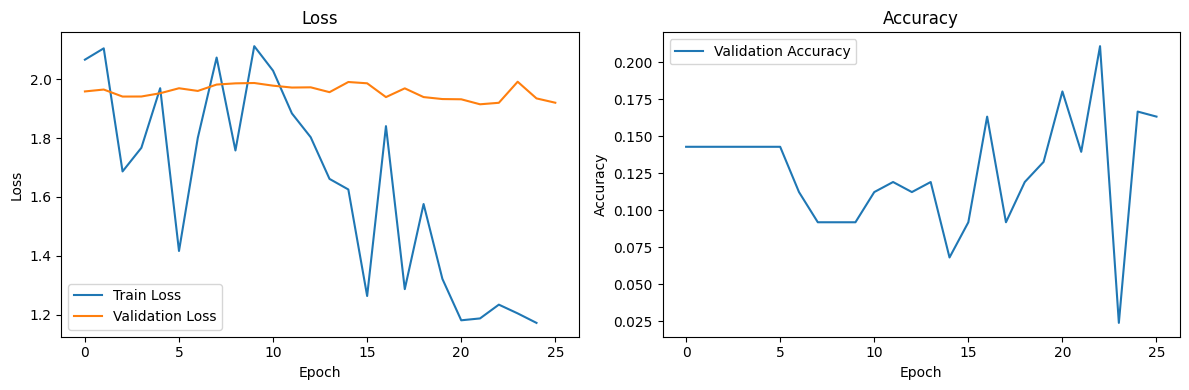

<Figure size 1000x800 with 0 Axes>

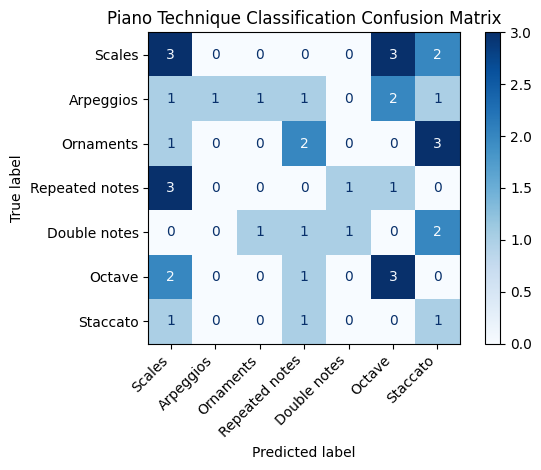


Per-class metrics:
Technique	Precision	Recall	F1-Score	Support
Scales	0.2727		0.3750	0.3158		8
Arpeggios	1.0000		0.1429	0.2500		7
Ornaments	0.0000		0.0000	0.0000		6
Repeated notes	0.0000		0.0000	0.0000		5
Double notes	0.5000		0.2000	0.2857		5
Octave	0.3333		0.5000	0.4000		6
Staccato	0.1111		0.3333	0.1667		3


In [47]:
# Plot training metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(metrics_callback.train_losses, label="Train Loss")
plt.plot(metrics_callback.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(metrics_callback.val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.savefig("training_metrics.png")
plt.show()

# Define piano technique class names (replace with your actual technique names)
technique_names = [
    "Scales",
    "Arpeggios",
    "Ornaments",
    "Repeated notes",
    "Double notes",
    "Octave",
    "Staccato",
]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=technique_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Piano Technique Classification Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# Calculate and print per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

print("\nPer-class metrics:")
print("Technique\tPrecision\tRecall\tF1-Score\tSupport")
for i, technique in enumerate(technique_names):
    print(
        f"{technique}\t{precision[i]:.4f}\t\t{recall[i]:.4f}\t{f1[i]:.4f}\t\t{support[i]}"
    )

# Classification with Augmentation

In [48]:
train_features_aug, train_labels_aug = u.get_spectrogram_and_labels(
    train_dataloader_filtered, augment=True
)
val_features_aug, val_labels_aug = u.get_spectrogram_and_labels(
    val_dataloader_filtered, augment=True
)
test_features_aug, test_labels_aug = u.get_spectrogram_and_labels(
    test_dataloader_filtered, augment=True
)
print(train_features_aug.shape)
print(train_labels_aug.shape)
print(val_features_aug.shape)
print(val_labels_aug.shape)
print(test_features_aug.shape)
print(test_labels_aug.shape)

Label for track: 0
Processing track 1/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/v72Hi1TIAFQ.wav
Original audio shape: (1984471,)
Track 0, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 2/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Doublenotes_6.wav
Original audio shape: (1352871,)
Track 1, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 3/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/7sdmulntks4.wav
Original audio shape: (3785596,)
Track 2, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 6
Processing track 4/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/9pmAuRz7AjE_cut.wav
Original audio shape: (684647,)
Track 3, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 5/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/FEjU3QR3Sds.wav
Original audio shape: (931214,)
Track 4, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 6/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/3XcgoAl5WvI_cut.wav
Original audio shape: (1357933,)
Track 5, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 7/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/sxlXBMYkbkQ.wav
Original audio shape: (2524474,)
Track 6, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 8/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/VZiM-rLNUos_cut.wav
Original audio shape: (3525497,)
Track 7, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 9/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/X9RX0Du0X_w.wav
Original audio shape: (1142422,)
Track 8, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 10/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/fjkKhLkyIMo.wav
Original audio shape: (6150131,)
Track 9, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 11/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/uDZdMMWyxtM.wav
Original audio shape: (1968310,)
Track 10, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 12/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/6VQ1wr28kik_cut.wav
Original audio shape: (3681159,)
Track 11, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 13/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/MwJ8MV26eZs.wav
Original audio shape: (1782178,)
Track 12, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 14/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/71qZ-BnhenI.wav
Original audio shape: (2780160,)
Track 13, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 15/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/hkgt_NcQF6s.wav
Original audio shape: (4072595,)
Track 14, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 6
Processing track 16/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/YYE3N8sVzyQ.wav
Original audio shape: (1758773,)
Track 15, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 17/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/B4qtWa7uzqQ.wav
Original audio shape: (2518016,)
Track 16, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 18/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/rPeR98tXglE.wav
Original audio shape: (1634500,)
Track 17, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 19/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/MvuVChCz2Gk.wav
Original audio shape: (465886,)
Track 18, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 20/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/BiL7YPcezpU.wav
Original audio shape: (1054929,)
Track 19, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 21/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/PAKtfkh0C1M_cut7.wav
Original audio shape: (665851,)
Track 20, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 22/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/GTEQhRwGwEI.wav
Original audio shape: (870470,)
Track 21, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 23/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/yWFzqMZvLYQ.wav
Original audio shape: (1900322,)
Track 22, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 24/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/b1GU9fpks4M.wav
Original audio shape: (1536976,)
Track 23, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 25/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_3.wav
Original audio shape: (891879,)
Track 24, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 26/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Repeatednotes_ravel_2.wav
Original audio shape: (960557,)
Track 25, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 27/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Nw1BAqrKvjM.wav
Original audio shape: (1438337,)
Track 26, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 28/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/qJ0KorNJHmI.wav
Original audio shape: (3381569,)
Track 27, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 29/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/rqnUhZLlgsU.wav
Original audio shape: (703286,)
Track 28, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 30/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/pJ5UmwxdaEM.wav
Original audio shape: (1205248,)
Track 29, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 31/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_franck_1.wav
Original audio shape: (1943693,)
Track 30, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 32/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/xXi3dl5R92c_cut5.wav
Original audio shape: (294179,)
Track 31, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 33/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/_lW2AXcugp4.wav
Original audio shape: (11693384,)
Track 32, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 34/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/M1dGRk9lYl4.wav
Original audio shape: (6335147,)
Track 33, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 35/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/ZNxCuihDFeU.wav
Original audio shape: (1100626,)
Track 34, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 36/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/GJ4qCMacMlA_cut2.wav
Original audio shape: (429808,)
Track 35, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 37/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/STy9GPeuNEY_cut.wav
Original audio shape: (479437,)
Track 36, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 38/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/5W-XBL5COxI.wav
Original audio shape: (1702488,)
Track 37, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 39/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/2g_ddZ-IceU.wav
Original audio shape: (3312466,)
Track 38, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 40/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/6IgJQ5aUiRU.wav
Original audio shape: (1044341,)
Track 39, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 41/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/eme_SAE6rok.wav
Original audio shape: (3964483,)
Track 40, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 6
Processing track 42/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Staccato_1.wav
Original audio shape: (697133,)
Track 41, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 43/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/RwBVzJFW46Q.wav
Original audio shape: (696042,)
Track 42, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 44/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/BqiSIOFQSFk.wav
Original audio shape: (1145766,)
Track 43, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 45/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/DhfTJRkP1es.wav
Original audio shape: (4192967,)
Track 44, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 46/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/2NofNw2QTAw.wav
Original audio shape: (4604239,)
Track 45, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 47/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Doublenotes_1.wav
Original audio shape: (707481,)
Track 46, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 48/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/ZXWcf-P3I3k.wav
Original audio shape: (315420,)
Track 47, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 49/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/AePvsx9w9f4_cut.wav
Original audio shape: (893486,)
Track 48, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 50/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_e_mior.wav
Original audio shape: (449703,)
Track 49, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 51/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/ri4-rYzHyjA.wav
Original audio shape: (449725,)
Track 50, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 52/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/CX4-RAL0TBo.wav
Original audio shape: (2454257,)
Track 51, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 53/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/N6HcdKlAzkE_cut.wav
Original audio shape: (2582334,)
Track 52, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 54/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_ravel_1.wav
Original audio shape: (2090457,)
Track 53, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 55/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_franck_3.wav
Original audio shape: (1175060,)
Track 54, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 56/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/S6Zf7bzha8w.wav
Original audio shape: (4802073,)
Track 55, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 57/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/VnH4b-eYQDc.wav
Original audio shape: (4344547,)
Track 56, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 58/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/caR2SSD2JlY.wav
Original audio shape: (1855182,)
Track 57, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 59/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/bdYhyPH6jbY.wav
Original audio shape: (1861312,)
Track 58, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 60/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/etq0pqpSNqQ.wav
Original audio shape: (559509,)
Track 59, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 61/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_5.wav
Original audio shape: (1085684,)
Track 60, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 62/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/rXcSlDXCfR8.wav
Original audio shape: (905021,)
Track 61, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 63/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/t_nxp263oUY.wav
Original audio shape: (1251649,)
Track 62, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 6
Processing track 64/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/g_jUWqYsNzw_cut.wav
Original audio shape: (2262309,)
Track 63, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 65/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/4QtkdA_coBQ.wav
Original audio shape: (1023722,)
Track 64, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 66/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/EDhSoKdU_hY.wav
Original audio shape: (913938,)
Track 65, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 67/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/dXVXdemjr8o.wav
Original audio shape: (1782736,)
Track 66, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 68/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/yCNL6URpwXQ.wav
Original audio shape: (614679,)
Track 67, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 69/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/HHRr0akDG-0.wav
Original audio shape: (3698103,)
Track 68, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 70/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/SiXmnSXShdc.wav
Original audio shape: (3643490,)
Track 69, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 71/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/lM6Ecj24-nU.wav
Original audio shape: (5407835,)
Track 70, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 72/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/w1JJaDFGxgU.wav
Original audio shape: (2980885,)
Track 71, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 73/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Y5CsDc2Cpzo.wav
Original audio shape: (3136366,)
Track 72, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 74/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/yBDSkjV5_wQ_cut.wav
Original audio shape: (1125961,)
Track 73, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 75/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Ri9ne7AV1K0.wav
Original audio shape: (6219790,)
Track 74, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 76/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/PAKtfkh0C1M_cut2.wav
Original audio shape: (505649,)
Track 75, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 6
Processing track 77/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/93VqAV8YDSY.wav
Original audio shape: (3251166,)
Track 76, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 78/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/cTii-snuNLc.wav
Original audio shape: (4869504,)
Track 77, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 79/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/nRV1tNXp1E0.wav
Original audio shape: (1787751,)
Track 78, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 80/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/6N6W0PDBRHs.wav
Original audio shape: (4837739,)
Track 79, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 81/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/BbVY3PQlpvs.wav
Original audio shape: (1256664,)
Track 80, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 82/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/0W_guhYZypI.wav
Original audio shape: (4016867,)
Track 81, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 83/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/wZnoYThr2As.wav
Original audio shape: (3202682,)
Track 82, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 84/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Doublenotes_5.wav
Original audio shape: (662324,)
Track 83, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 85/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/qcsNTWUKfmY.wav
Original audio shape: (2232460,)
Track 84, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 86/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/BYVIhBTElEs.wav
Original audio shape: (941245,)
Track 85, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 87/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Doublenotes_4.wav
Original audio shape: (834489,)
Track 86, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 6
Processing track 88/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/79VIXjBFK_I.wav
Original audio shape: (1778278,)
Track 87, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 89/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Sl1Z_dglxlo.wav
Original audio shape: (3946650,)
Track 88, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 90/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/te5duc9WAh0.wav
Original audio shape: (747869,)
Track 89, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 91/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/V52WdeAhadQ.wav
Original audio shape: (1787751,)
Track 90, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 92/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_franck_2.wav
Original audio shape: (1538208,)
Track 91, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 93/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/gq1W0DAb6pU.wav
Original audio shape: (2108187,)
Track 92, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 94/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/rFh7RwyfgI0.wav
Original audio shape: (2880018,)
Track 93, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 95/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/5MLsm8mh-0I.wav
Original audio shape: (1632270,)
Track 94, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 96/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/IbN6Hsjn2lg.wav
Original audio shape: (1822303,)
Track 95, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 97/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Ornaments_2.wav
Original audio shape: (1058400,)
Track 96, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 98/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/faAJ3HbGD_g.wav
Original audio shape: (2116546,)
Track 97, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 99/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/C3G8DUFYQjk.wav
Original audio shape: (1187005,)
Track 98, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 100/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/-0gQ_A3tP1c.wav
Original audio shape: (3635688,)
Track 99, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 101/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/I5rASCtR6Bo.wav
Original audio shape: (2192336,)
Track 100, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 102/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/31_T8OKn4-w.wav
Original audio shape: (5239537,)
Track 101, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 103/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_1.wav
Original audio shape: (1575840,)
Track 102, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 104/104: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/0YyH44KJ2S8.wav
Original audio shape: (2769677,)
Track 103, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Shuffling augmented dataset...
Execution completed, saving features and tensor as .pt file
Feature tensor shape: torch.Size([520, 6, 1500, 128])
Label tensor shape: torch.Size([520])
Project directory: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent
Saving features and labels to: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented
Features and labels saved successfully for split 'train' in c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented.
Label for track: 5
Processing track 1/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/McoqNuF6TpQ.wav
Original audio shape: (4155072,)
Track 0, resample from 48000 to 24000
Ta

c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 2/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/JrJHc__2jOk.wav
Original audio shape: (635298,)
Track 1, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 3/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/7qb62i2cO-s.wav
Original audio shape: (633069,)
Track 2, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 4/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/ZA6RuaHSB8A_cut.wav
Original audio shape: (892317,)
Track 3, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 5/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Bei7Hazlwjg.wav
Original audio shape: (1681868,)
Track 4, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 6
Processing track 6/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Staccato_3.wav
Original audio shape: (798740,)
Track 5, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 7/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/ttp2QX0O9ko.wav
Original audio shape: (10666876,)
Track 6, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 8/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/xXi3dl5R92c_cut2.wav
Original audio shape: (285481,)
Track 7, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 9/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/MP_3kWh0Gr4.wav
Original audio shape: (2153326,)
Track 8, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 10/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_4.wav
Original audio shape: (938919,)
Track 9, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 11/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Z2A1Fm_luXs.wav
Original audio shape: (2909554,)
Track 10, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 12/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/JRiumYw-buA_cut1.wav
Original audio shape: (399142,)
Track 11, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 13/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Ornaments_3.wav
Original audio shape: (1233389,)
Track 12, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 14/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/cosIrQauQbU_cut.wav
Original audio shape: (844516,)
Track 13, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 15/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/UM-Rx6c1Ny0.wav
Original audio shape: (747312,)
Track 14, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 16/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/PAKtfkh0C1M_cut3.wav
Original audio shape: (1221668,)
Track 15, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 17/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/YPds_ZgooTs.wav
Original audio shape: (1565954,)
Track 16, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 18/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/pGGHFf8XZAQ.wav
Original audio shape: (2993703,)
Track 17, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 19/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_e7.wav
Original audio shape: (644448,)
Track 18, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 20/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_6.wav
Original audio shape: (892820,)
Track 19, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 21/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/nsXT6p3AsrM.wav
Original audio shape: (2703918,)
Track 20, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 22/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/xXi3dl5R92c_cut1.wav
Original audio shape: (432912,)
Track 21, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 23/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/VYa5Rt1kKzQ.wav
Original audio shape: (6304497,)
Track 22, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 24/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/UhG9pPAcsHg.wav
Original audio shape: (1440009,)
Track 23, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 25/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Ornaments_1.wav
Original audio shape: (766752,)
Track 24, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 26/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_1.wav
Original audio shape: (814733,)
Track 25, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 27/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/ro0QRhprRf4.wav
Original audio shape: (3440640,)
Track 26, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 28/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/QJ7MU87qDrc.wav
Original audio shape: (3022681,)
Track 27, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 29/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/piECZCUMquY.wav
Original audio shape: (750655,)
Track 28, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 30/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/YAWrQ_OrOvc.wav
Original audio shape: (1982799,)
Track 29, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 31/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Ornaments_4.wav
Original audio shape: (1003833,)
Track 30, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 32/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/jKjLp38TY5w.wav
Original audio shape: (12592275,)
Track 31, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 33/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Yr50r0XOqe8.wav
Original audio shape: (212881,)
Track 32, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 34/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/fi23cCYyv2U.wav
Original audio shape: (769045,)
Track 33, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 35/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/HXpsEFQsAFc.wav
Original audio shape: (9143276,)
Track 34, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 36/36: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Repeatednotes_ravel_1.wav
Original audio shape: (429945,)
Track 35, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Shuffling augmented dataset...
Execution completed, saving features and tensor as .pt file
Feature tensor shape: torch.Size([180, 6, 1500, 128])
Label tensor shape: torch.Size([180])
Project directory: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent
Saving features and labels to: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented
Features and labels saved successfully for split 'val' in c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented.
Label for track: 0
Processing track 1/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/5YTmfv63-wY.wav
Original audio shape: (697714,)
Track 0, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 2/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_e7dim.wav
Original audio shape: (635981,)
Track 1, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 6
Processing track 3/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Staccato_2.wav
Original audio shape: (1261613,)
Track 2, resample from 44100 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 4/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/kqWDdHF_OWg.wav
Original audio shape: (1189234,)
Track 3, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 5/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/IknNg8SSKkM.wav
Original audio shape: (3468504,)
Track 4, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 6
Processing track 6/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/xnf_eve4aeU.wav
Original audio shape: (6105548,)
Track 5, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 7/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Repeatednotes_1.wav
Original audio shape: (795917,)
Track 6, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 8/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/StMcY3iICGQ.wav
Original audio shape: (3526461,)
Track 7, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 9/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/jRKisjW2nnM.wav
Original audio shape: (7686549,)
Track 8, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 10/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/G0arFYjFKb4.wav
Original audio shape: (970780,)
Track 9, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 11/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/6MIKbwQ1PGQ.wav
Original audio shape: (5519848,)
Track 10, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 12/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/YUcCcNROo4o.wav
Original audio shape: (2399086,)
Track 11, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 13/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/aarUpTRqAdc.wav
Original audio shape: (873257,)
Track 12, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 14/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/VFAUWbTgXr8.wav
Original audio shape: (2078651,)
Track 13, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 15/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Repeatednotes_2.wav
Original audio shape: (905049,)
Track 14, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 16/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_eb_minor.wav
Original audio shape: (528729,)
Track 15, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 17/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Arpeggios_eb_major.wav
Original audio shape: (938944,)
Track 16, resample from 44100 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 18/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/9gYLJSFdNKw.wav
Original audio shape: (1325210,)
Track 17, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 19/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/tHoVTbZEab8.wav
Original audio shape: (1674066,)
Track 18, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 20/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/2nRGtXQi1ys.wav
Original audio shape: (8261660,)
Track 19, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 21/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_2.wav
Original audio shape: (2098925,)
Track 20, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 22/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/3iqZOeqZ0GY_cut.wav
Original audio shape: (3161820,)
Track 21, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 23/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/mumalDzmPi0.wav
Original audio shape: (3865287,)
Track 22, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 24/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Okp8b6PrefA.wav
Original audio shape: (1211525,)
Track 23, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 25/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/kKaNutM8_Nc.wav
Original audio shape: (1194806,)
Track 24, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 0
Processing track 26/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/GmAxDLJW5-U.wav
Original audio shape: (622481,)
Track 25, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 27/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/PAKtfkh0C1M_cut1.wav
Original audio shape: (977760,)
Track 26, resample from 48000 to 24000
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 28/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/SSjOS2EdmGE.wav
Original audio shape: (1547564,)
Track 27, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 29/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/GJ4qCMacMlA_cut1.wav
Original audio shape: (440918,)
Track 28, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 30/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/2yt9NdixgoU.wav
Original audio shape: (3006520,)
Track 29, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 4
Processing track 31/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Doublenotes_3.wav
Original audio shape: (736647,)
Track 30, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 32/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/wjaG3ZVKnR0.wav
Original audio shape: (8228781,)
Track 31, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 33/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/Octave_ravel_2.wav
Original audio shape: (1053696,)
Track 32, resample from 44100 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 34/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/9WgnouU8Cbc_cut.wav
Original audio shape: (1554061,)
Track 33, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 5
Processing track 35/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/bPxQ-T4ysyo.wav
Original audio shape: (1361990,)
Track 34, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 3
Processing track 36/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/PAKtfkh0C1M_cut4.wav
Original audio shape: (454374,)
Track 35, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000
Applying augmentation strategy 2


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 1
Processing track 37/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/3TVN_pBzzy4.wav
Original audio shape: (2430851,)
Track 36, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 38/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/U7bpgJOVuoE_cut.wav
Original audio shape: (5637187,)
Track 37, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 6
Processing track 39/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/UGA9cr9805A_cut.wav
Original audio shape: (968063,)
Track 38, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Target length in samples: 1440000
Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Label for track: 2
Processing track 40/40: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\data\techniques/JQGCecX2d_Q_cut2.wav
Original audio shape: (537479,)
Track 39, resample from 48000 to 24000
Target length in samples: 1440000
Applying augmentation strategy 1
Target length in samples: 1440000


c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Applying augmentation strategy 2
Target length in samples: 1440000
Applying augmentation strategy 3
Target length in samples: 1440000
Applying augmentation strategy 4
Target length in samples: 1440000
Shuffling augmented dataset...
Execution completed, saving features and tensor as .pt file
Feature tensor shape: torch.Size([200, 6, 1500, 128])
Label tensor shape: torch.Size([200])
Project directory: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent
Saving features and labels to: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented
Features and labels saved successfully for split 'test' in c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented.
torch.Size([520, 6, 1500, 128])
torch.Size([520])
torch.Size([180, 6, 1500, 128])
torch.Size([180])
torch.Size([200, 6, 1500, 128])
torch.Size([200])


In [49]:
from utils import load_features_and_labels

# Load features and labels for a specific data split
split_name = "train"  # Replace with "val" or "test" as needed
folder_name = "spectrogram"  # Match the folder name used when saving

try:
    train_features_aug, train_labels_aug = load_features_and_labels(
        split_name, folder_name, augment=True
    )
    val_features_aug, val_labels_aug = load_features_and_labels(
        "val", folder_name, augment=True
    )
    test_features_aug, test_labels_aug = load_features_and_labels(
        "test", folder_name, augment=True
    )

    # Display the loaded tensors
    print(f"Features shape: {train_features_aug.shape}")
    print(f"Labels shape: {train_labels_aug.shape}")
    print(f"Validation Features shape: {val_features_aug.shape}")
    print(f"Validation Labels shape: {val_labels_aug.shape}")
    print(f"Test Features shape: {test_features_aug.shape}")
    print(f"Test Labels shape: {test_labels_aug.shape}")

    # # Example: inspect the first sample
    # print(f"First feature vector: {features[0]}")
    # print(f"First label: {labels[0]}")

except FileNotFoundError as e:
    print(e)

Loading features and labels from: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented


c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\feature_spectrogram\utils.py:713: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(features_p

Features and labels successfully loaded for split 'train' from c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented.
Loading features and labels from: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented
Features and labels successfully loaded for split 'val' from c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented.
Loading features and labels from: c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented
Features and labels successfully loaded for split 'test' from c:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\computed_features\spectrogram_augmented.
Features shape: torch.Size([520, 6, 1500, 128])
Labels shape: torch.Size([520])
Validation Features shape: torch.Size([180, 6, 1500, 128])
Validation Labels shape: torch.Size([180])
Test Features shape: torch.Size([200, 6, 1500, 128])
Tes

In [50]:
# # parameters for 2 below cells execution, adjust as needed
# batch_size = 8  # Batch size for training and validation,
# num_workers = 8  # Number of workers for data loading

In [51]:
from torchinfo import summary
import torch
from single_label_classifier import SingleLabelClassifier, ModelConfig, TrainingConfig

# Define dimensions for your embeddings
train_features_shape = train_features_aug.shape
print(f"Train features shape: {train_features_shape}")
# eg (batch_size, n_segs, embedding_frame_rate, embedding_dim)
n_segs = train_features_shape[1]  # Number of segments
print(f"Number of segments (n_segs): {n_segs}")

embedding_dim = train_features_shape[3]  # Dimension of each embedding vector
embedding_len = train_features_shape[2]  # Length of each embedding vector
# batch_size = train_features_shape[0]
batch_size = batch_size  # Set batch size for the model
# Create custom configurations using these values
# model_config = ModelConfig(
#     num_encoder_layers=2,
#     dim_transformer=128,
#     dim_feedforward=64,
#     dropout=0.1,
#     nhead=2,
#     cnn_channels=32,
#     kernel_size=3,
#     padding=1,
#     stride=1,
# )

model_config = ModelConfig(
    num_encoder_layers=2,
    dim_transformer=128,
    dim_feedforward=64,
    dropout=0.1,
    nhead=2,
    cnn_channels=64,
    kernel_size=3,
    padding=1,
    stride=1,
)

training_config = TrainingConfig(
    learning_rate=1e-4,  # 1e-4 default
    weight_decay=1e-5,
    num_classes=7,  # For the piano techniques
    n_segs=n_segs,  # Using the value from your shape
)
# Create an instance of the model
import torch

torch.set_float32_matmul_precision("medium")  # Set precision for better performance
aug_model = SingleLabelClassifier(
    embedding_dim=embedding_dim,
    embedding_len=embedding_len,
    training_config=training_config,
    model_config=model_config,
)

# Use torchinfo to create a detailed summary
# Define the input shape for the summary function
print(aug_model.training_config.n_segs)
input_size = (
    batch_size,
    aug_model.training_config.n_segs,
    embedding_len,
    embedding_dim,
)

# Generate the summary
model_summary = summary(
    aug_model,
    input_size=input_size,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=3,  # Adjust depth to see more or fewer nested layers
    verbose=1,  # Set to 2 for even more details
)

# The summary is automatically printed, but you can also access it as a string
summary_str = str(model_summary)

Train features shape: torch.Size([520, 6, 1500, 128])
Number of segments (n_segs): 6
6
Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
SingleLabelClassifier                              [6, 6, 1500, 128]         [6, 7]                    --                        True
├─AudioCNNTransformer: 1-1                         [6, 6, 1500, 128]         [6, 7]                    --                        True
│    └─ConvBlock: 2-1                              [36, 1, 1500, 128]        [36, 64, 1500, 128]       --                        True
│    │    └─Conv2d: 3-1                            [36, 1, 1500, 128]        [36, 64, 1500, 128]       640                       True
│    │    └─BatchNorm2d: 3-2                       [36, 64, 1500, 128]       [36, 64, 1500, 128]       128                       True
│    │    └─ReLU: 3-3                              [36, 64, 1500, 128]       [36, 64, 1500, 128]       -

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import os
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import Callback
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support


# Create a callback to track metrics during training
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Convert tensor to CPU and then to float
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            if isinstance(train_loss, torch.Tensor):
                train_loss = train_loss.cpu().item()
            self.train_losses.append(train_loss)

    def on_validation_epoch_end(self, trainer, pl_module):
        # Convert tensor to CPU and then to float
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            if isinstance(val_loss, torch.Tensor):
                val_loss = val_loss.cpu().item()
            self.val_losses.append(val_loss)

        val_accuracy = trainer.callback_metrics.get("val_accuracy")
        if val_accuracy is not None:
            if isinstance(val_accuracy, torch.Tensor):
                val_accuracy = val_accuracy.cpu().item()
            elif hasattr(val_accuracy, "compute"):  # Handle torchmetrics
                val_accuracy = val_accuracy.compute().cpu().item()
            self.val_accuracies.append(val_accuracy)


# Create PyTorch datasets
train_dataset = TensorDataset(train_features_aug, train_labels_aug)
val_dataset = TensorDataset(val_features_aug, val_labels_aug)
test_dataset = TensorDataset(test_features_aug, test_labels_aug)

# Set batch size and create data loaders
batch_size = batch_size  # definition from above cell
num_workers = num_workers  # Adjust based on your system's capabilities
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)

# Create checkpoint directory
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Setup checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="audio_classifier-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
)

# Create metrics callback
metrics_callback = MetricsCallback()


# Initialize trainer
trainer = Trainer(
    max_epochs=15,
    accelerator="auto",  # Uses GPU if available
    callbacks=[checkpoint_callback, metrics_callback],
    enable_progress_bar=True,
    log_every_n_steps=25,  # Log every x steps
)

# Train the model
trainer.fit(aug_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\piano_judges_latent\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\feature_spectrogram\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | AudioCNNTransformer | 24.7 M | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | f1        | MulticlassF1Score   | 0      | train
4 | precision | MulticlassPrecision | 0      | train
5 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
98.997    T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


In [53]:
# Function to collect test predictions
def collect_predictions(model, test_loader):
    model.eval()
    device = next(model.parameters()).device
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            # Forward pass
            y_hat = model(x)
            preds = torch.argmax(y_hat, dim=1)

            # Collect predictions and targets (make sure they're integers)
            all_preds.extend(preds.cpu().numpy().astype(int))
            all_targets.extend(y.cpu().numpy().astype(int))

    return np.array(all_preds), np.array(all_targets)


# Run standard test to get metrics
test_results = trainer.test(aug_model, test_loader)
print(f"Test results: {test_results}")

# Get predictions for confusion matrix
y_pred, y_true = collect_predictions(aug_model, test_loader)

# Ensure y_pred and y_true are of the right shape and type
print(f"Predictions shape: {y_pred.shape}, type: {y_pred.dtype}")
print(f"True labels shape: {y_true.shape}, type: {y_true.dtype}")

# Get the best model path
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")
print(f"y_true shape: {y_true.shape}, type: {type(y_true)}")
print(f"y_pred shape: {y_pred.shape}, type: {type(y_pred)}")
print(y_true)
print(y_pred)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.20891156792640686    │
│          test_f1          │    0.17780862748622894    │
│         test_loss         │    1.8562921285629272     │
│      test_precision       │    0.17421583831310272    │
│        test_recall        │    0.20891156792640686    │
└───────────────────────────┴───────────────────────────┘

Test results: [{'test_loss': 1.8562921285629272, 'test_accuracy': 0.20891156792640686, 'test_f1': 0.17780862748622894, 'test_precision': 0.17421583831310272, 'test_recall': 0.20891156792640686}]
Predictions shape: (200,), type: int64
True labels shape: (200,), type: int64
Best model saved at: C:\Repository\DL4M\DL4M_Final_Piano_Judges_with_Music2Latent\feature_spectrogram\checkpoints\audio_classifier-epoch=17-val_loss=1.8946.ckpt
y_true shape: (200,), type: <class 'numpy.ndarray'>
y_pred shape: (200,), type: <class 'numpy.ndarray'>
[0 4 0 5 0 4 1 0 5 4 1 1 4 6 0 5 4 2 5 6 5 4 1 2 6 5 4 4 6 1 5 4 2 4 3 5 0
 6 2 2 4 0 1 2 2 2 1 4 1 3 0 3 5 2 6 0 1 1 0 0 1 5 3 1 3 0 5 3 6 0 0 1 5 1
 1 5 2 4 6 3 0 3 2 2 3 1 1 2 0 0 4 0 6 2 4 3 5 2 3 5 5 1 2 0 0 5 5 6 3 4 5
 3 3 5 5 3 0 2 1 3 4 5 6 1 1 0 0 6 5 3 1 2 4 4 0 1 6 1 2 0 0 1 2 1 3 2 2 0
 4 1 3 0 0 3 2 2 5 1 3 1 3 3 2 4 0 0 1 2 1 0 2 5 6 0 4 0 5 0 0 5 2 3 5 2 4
 6 5 3 4 1 0 1 1 0 5 4 1 0 2 0]
[5 0 4 0 1 4 4 0 5 0 6 0 0 4 0 0 2 4 5 5 5 0 1 5 1 0 1 

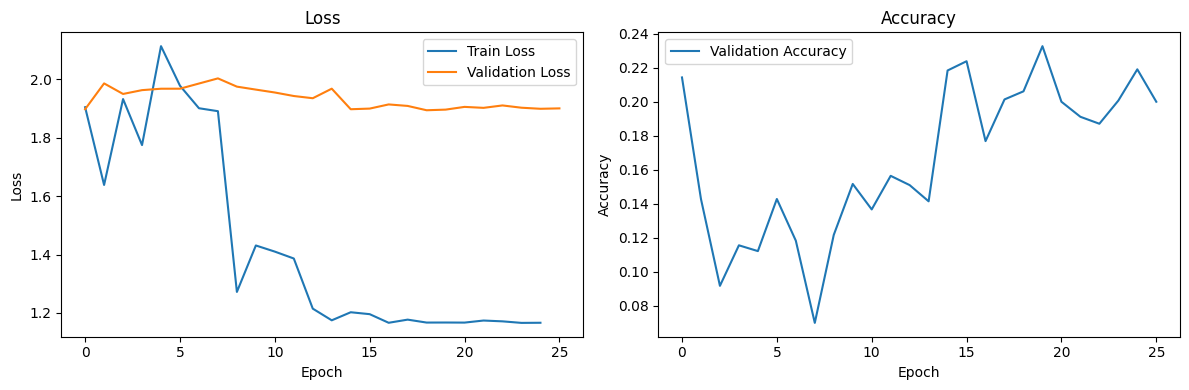

<Figure size 1000x800 with 0 Axes>

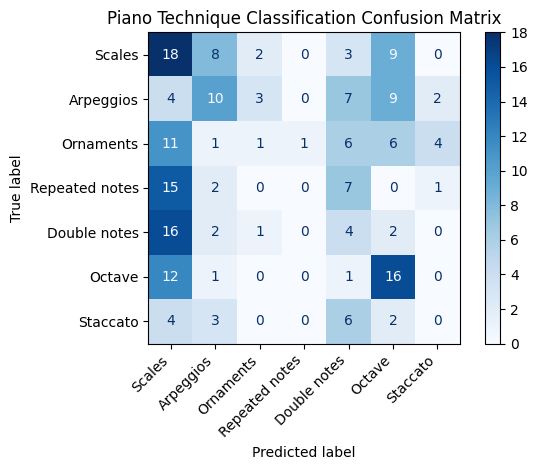


Per-class metrics:
Technique	Precision	Recall	F1-Score	Support
Scales	0.2250		0.4500	0.3000		40
Arpeggios	0.3704		0.2857	0.3226		35
Ornaments	0.1429		0.0333	0.0541		30
Repeated notes	0.0000		0.0000	0.0000		25
Double notes	0.1176		0.1600	0.1356		25
Octave	0.3636		0.5333	0.4324		30
Staccato	0.0000		0.0000	0.0000		15


In [54]:
# Plot training metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(metrics_callback.train_losses, label="Train Loss")
plt.plot(metrics_callback.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(metrics_callback.val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.savefig("training_metrics.png")
plt.show()

# Define piano technique class names (replace with your actual technique names)
technique_names = [
    "Scales",
    "Arpeggios",
    "Ornaments",
    "Repeated notes",
    "Double notes",
    "Octave",
    "Staccato",
]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=technique_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Piano Technique Classification Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# Calculate and print per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

print("\nPer-class metrics:")
print("Technique\tPrecision\tRecall\tF1-Score\tSupport")
for i, technique in enumerate(technique_names):
    print(
        f"{technique}\t{precision[i]:.4f}\t\t{recall[i]:.4f}\t{f1[i]:.4f}\t\t{support[i]}"
    )

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import pandas as pd
import json

# Generate confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=technique_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Piano Technique Classification Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("confusion_matrix.png")  # Save plot as PNG
plt.show()

# Save confusion matrix as CSV and JSON
cm_df = pd.DataFrame(cm, index=technique_names, columns=technique_names)
cm_df.to_csv("confusion_matrix.csv", index=True)  # Save as CSV

cm_dict = cm_df.to_dict()  # Convert to dictionary for JSON format
with open("confusion_matrix.json", "w") as json_file:
    json.dump(cm_dict, json_file)

# Calculate and print per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

print("\nPer-class metrics:")
print("Technique\tPrecision\tRecall\tF1-Score\tSupport")
for i, technique in enumerate(technique_names):
    print(
        f"{technique}\t{precision[i]:.4f}\t\t{recall[i]:.4f}\t{f1[i]:.4f}\t\t{support[i]}"
    )
